## Robot programming workshop 03

<div class="alert alert-block alert-info">For this workshop you will be developing a maze solving robot. You will connect your solution to your CoppeliaSim robot (via your robot wrapper class) and reimplement your line tracer robot with your implementation of the behaviour to solve the maze. Make sure you have save sim.py, simConst.py and remoteApi.dll files to a directory and also downloaded the 03_line_tracker_maze_vrep.ttt to the same location</div>

<font color="red"><b>Task 1:</b></font> Change directory - to the working directory where you have saved <b>sim.py, simConst.py</b><i>(or vrepConst.py)</i> and <b>remoteApi.dll</b> and load the API library

In [156]:
import sys, os
import numpy as np
import random
desiredPath = "S:\\Downloads" # set this path to your working folder
os.chdir(desiredPath)
print("Current working directory: {}".format(os.getcwd()))   # sanity check
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time

Current working directory: s:\Downloads


<font color="red"><b>Task 2:</b></font> The line tracer robot class. In future workshops this can be imported from a file in the same directory as <b>sim.py, etc</b> but is here for your reference.

In [157]:
class LineTracerRobot:

    def __init__(self, sim, clientID):
        self._sim = sim
        self.clientID = clientID
        errCode = [0] * 5
        ## attach actuators and sensors
        errCode[0], self.LM= sim.simxGetObjectHandle(clientID, "DynamicLeftJoint", sim.simx_opmode_oneshot_wait )
        errCode[1], self.RM = sim.simxGetObjectHandle(clientID, "DynamicRightJoint", sim.simx_opmode_oneshot_wait)
        
        errCode[2], self.LS = sim.simxGetObjectHandle(clientID, "LeftSensor", sim.simx_opmode_oneshot_wait)
        errCode[3], self.RS = sim.simxGetObjectHandle(clientID, "RightSensor", sim.simx_opmode_oneshot_wait)
        errCode[4], self.MS = sim.simxGetObjectHandle(clientID, "MiddleSensor", sim.simx_opmode_oneshot_wait)
        
        
        
        
    def _set_two_motor(self, left: float, right: float):
        self.leftMotor = sim.simxSetJointTargetVelocity(clientID,self.LM,left,sim.simx_opmode_streaming)
        self.rightMotor = sim.simxSetJointTargetVelocity(clientID,self.RM,right,sim.simx_opmode_streaming)
        ## set the left motor to the to the value in left
        ## the right motor to the value in right

    def right_sensor(self):
        ## return the value from the rigth sensor
        return self._sim.simxReadVisionSensor(self.clientID,self.RS,self._sim.simx_opmode_oneshot_wait)[1]
    
    def mid_sensor(self):
        ## return the value from the middle sensor
        return self._sim.simxReadVisionSensor(self.clientID,self.MS,self._sim.simx_opmode_oneshot_wait)[1]

    def left_sensor(self):
        ## return the value from the left sensor
        return self._sim.simxReadVisionSensor(self.clientID,self.LS,self._sim.simx_opmode_oneshot_wait)[1]
        
    def rotate_right(self, speed=2.0):
        ## turn the robot right
        self._set_two_motor(speed, -speed)
    
    def turn_right(self, speed=2.0): #Own Function for turning right###############################################
        ## turn the robot right
        self._set_two_motor(speed, speed/2)
    
    def turn_left(self, speed=2.0):#Own Function for turning left##################################################
        ## turn the robot right
        self._set_two_motor(speed/2, speed)
    
    def u_turn(self, speed=2.0):
        self._set_two_motor(-speed, speed)
        

    def rotate_left(self, speed=2.0):
        ## turn the robot left
        self._set_two_motor(-speed, speed)

    def move_forward(self, speed=2.0):
        ## move the robot forward
        self._set_two_motor(speed, speed)

    def move_backward(self, speed=2.0):
        ## move the robot backwards
        self._set_two_motor(-speed, -speed)

    def stop(self):
        self._set_two_motor(0.0, 0.0)

<font color="red"><b>Task 3:</b></font> The robot should move forward until it encouters various points along the maze until it reaches the end where it should stop.

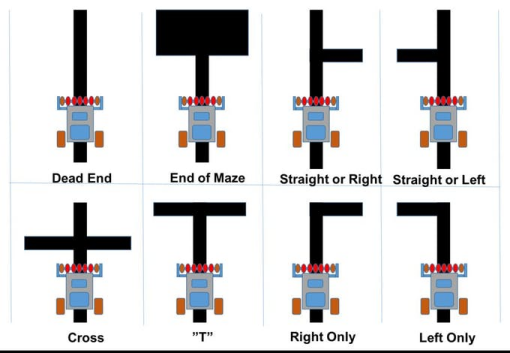

You will have to work out the sensor settings to recognize the details of the various types of junction in the maze. A first of the algorithm for solving the maze could be characterized as follows:

<code>if At a "Cross":
	Go to Left, or
	Go to Right, or
	Go Straight
else if At a "T":
	Go to Left, or
	Go to Right
else if At a "Right Only":
	Go to Right
else if At a "Left Only":
	Go to Left
else if At "Straight or Left":
	Go to Left, or
	Go Straight
else if At "Straight or Right":
	Go to Right, or
	Go Straight
else if At a "Dead End":
	Go back ("U turn")
else if At "End of Maze":
	Stop</code>
    
But to ensure the robot is able to quickly reach the end of the maze, <i>(rather than going round in circles)</i> we can use the <b>"Left-Hand Rule"</b> to solve the maze:

-	At a "Cross": Go to Left
-	At a "T": Go to Left
-	At a "Right Only": Go to Right
-	At a "Left Only": Go to Left
-	At a "Straight or Left": Go to Left
-	At a "Straight or Right": Go Straight
-	At a "Dead End": Go back ("U turn")
-	At the "End of Maze": Stop


<font color="red"><b>Task 4:</b></font> To detect the kind of junction the robot is facing requires moving the robot a small distance forward and depending on what signal is detected on the sensors then deciding what action to take.</i>

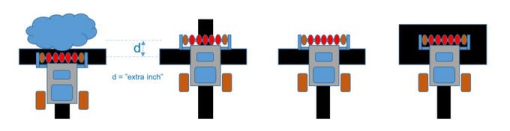

<i>Hint: One possible strategy is described in the following pseudo code:</i>

<code>if At a "DEAD END":
	Go back ("U turn")
else if At a "LINE": Run an extra inch
	If there is a line: It is a "Cross" ==> Go to LEFT
	If There is no line: it is a "T" ==> Go to LEFT
	If there is another line: it is the "End of Maze" ==> STOP
else if At a "RIGHT TURN": Run an extra inch
	if there is a line: It is a Straight or Right ==> Go STRAIGHT
	If there is no line: it is a Right Only ==> Go to RIGHT
else if At a "LEFT TURN": Run an extra inch
	if there is a line: It is a Straight or LEFT ==> Go to LEFT
	If there is no line: it is a LEFT Only ==> Go to LEFT</code>


In [198]:
print ('Program started')
sim.simxFinish(-1) # just in case, close all opened connections

clientID=sim.simxStart('127.0.0.1',19997,True,True,5000,5) # Connect to CoppeliaSim

if clientID != -1:
    print ('Connected to remote API server')
else:
    print('Connection failed!!')
    sys.exit('Could not connect')

bot = LineTracerRobot(sim, clientID)

startTime=time.time()
endTime = 300


bot.move_forward(1)
time.sleep(1)
while time.time()-startTime < endTime:
    counter = 0
    sensorReading = [bot.left_sensor(),bot.mid_sensor(),bot.right_sensor()]
    ts = 0.4
    rs = 0.3
    
    if sensorReading[2] == False:
        bot.turn_right(ts)
        
    if sensorReading[2] == False and sensorReading[1] == False and sensorReading[0]== True:
            bot.move_forward(0.2)


    if sensorReading[0] == False and sensorReading[1] == False:
        bot.turn_left(ts)
        counter += 1
        print(counter)
        if counter >= 3:
            bot.rotate_left(0.5)
            print("turning")
            
            
    elif sensorReading[0] == True and sensorReading[1] == False and sensorReading[2] == True:
        bot.move_forward(0.2)
      
        
    elif sensorReading[0] == True and sensorReading[1] == True and sensorReading[2] == True:
        bot.rotate_left(0.2)
        
    
    if sensorReading[0] == False and sensorReading[1] == False and sensorReading[2] == False:
        endcheck = time.time()
        bot.move_forward(0.5)
        time.sleep(0.5)
        if endcheck - startTime > 90:
            bot.stop()
            print("End of Maze") 
        time.sleep(0.5)
        if endcheck - startTime < 90:
            bot.rotate_left(0.5)
            time.sleep(0.1)
            print("Meant to turn")
        
    
    
        
    
    #print(leftS,midS,rightS)
    
    
bot.stop()
time.sleep(0.5)    ## delay to execute the command
sim.simxFinish(-1) ## just in case, close all opened connections
print("...done")

Program started
Connected to remote API server
Meant to turn
Meant to turn
End of Maze


KeyboardInterrupt: 

<font color="red"><b>Task 5:</b></font> Edit and modify the code below to implement your robot's behaviour. Make sure the V-rep/CoppeliaSim is on, has the 03_line_tracker_maze_vrep.ttt scene loaded and the simulation is running. 

<div class="alert alert-block alert-danger">That is the end for this workbook. When you shutdown CoppeliaSim it will offer you the opportunity to save changes, select <b>No</b>. And remember to save your workbook before you shutdown. Next week: we will add some logical structure and OO design to our robot code. </div>